# **IMPORTADO DE MÓDULOS**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

import tensorflow as tf
tf.version.VERSION 

In [2]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [3]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

# **PREPROCESSING AND FUNCTIONS**

In [4]:
start = 50
stop = 80
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28[:,start:stop,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28[:,start:stop,:],  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55[:,start:stop,:],  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82[:,start:stop,:],  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 30
Time step: 0.20
New number of time points: 240
New time step: 0.0250


Text(0.5, 1.0, 'Real pulses')

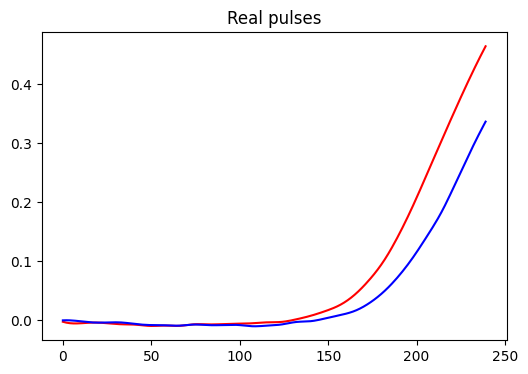

In [5]:
plt.figure(figsize=(6,4))

plt.plot(new_V28[0,:,0],'r-')
plt.plot(new_V28[0,:,1],'b-')
plt.title('Real pulses')

In [6]:
def weights_definition(NM, Npoints):
  t = np.linspace(0,Npoints, Npoints)/float(Npoints) #Normalized array of time
  Weights = np.zeros((Npoints,NM))
  NMW = int(NM/3) #Number of Moments per weight

  for i in range(NMW):
    Weights[:,i] = t**(i+1)

  for i in range(NMW):
    Weights[:,i + NMW] = np.exp(-t**(i))

  for i in range(NMW):
    Weights[:,i + 2*(NMW)] = np.exp(-(i)*t)

  return Weights

In [7]:
NM = 12
weights = weights_definition(NM,Nt_new)
print(weights.shape)

(240, 12)


# **NN MODEL DEFINITION**

In [56]:
from tensorflow.keras.initializers import Constant

def model_definition(N_time_points):

  inputA = Input(shape=(N_time_points,))
  inputB = Input(shape=(N_time_points,))

  x1 = Dense(NM, activation="relu", kernel_initializer=Constant(weights), bias_initializer='zeros')
  #x1 = Dense(NM, activation="relu",kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x2 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x3 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x4 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x5 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  op4A = x4(op3A)
  outA = x5(op4A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  op4B = x4(op3B)
  outB = x5(op4B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

In [52]:
INPUT = np.concatenate((new_V28,new_V55,new_V82), axis = 0)
Ncasos=INPUT.shape[0]
print(INPUT.shape)

(736, 240, 2)


# **DETECTOR 0**

In [10]:
INPUT_dec0 = np.zeros_like(INPUT)
REF_dec0 = np.zeros((Ncasos,),dtype=np.float32)


NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-4, size=N0)
  INPUT_dec0[i,:,0]=np.roll(INPUT[i,:,0],N0)
  INPUT_dec0[i,0:N0,0] = noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-4, size=N1)
  INPUT_dec0[i,:,1]=np.roll(INPUT[i,:,0],N1)
  INPUT_dec0[i,0:N1,1] = noise1
  REF_dec0[i]=new_time_step*(N0-N1)  #in ns


trainX_dec0 = INPUT_dec0[:,:,:]
REF_train_dec0 = REF_dec0[:]

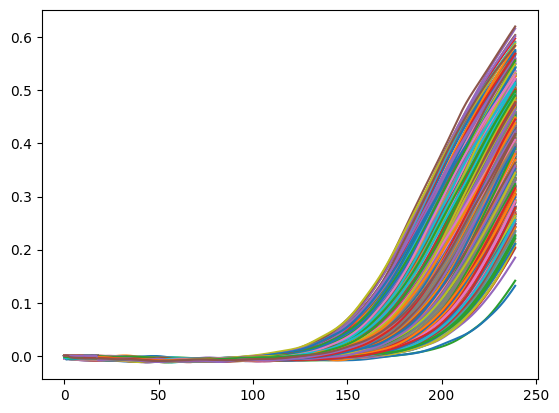

In [11]:
for i in range(INPUT_dec0.shape[0]):
  plt.plot(INPUT_dec0[i,:,0])

# **DETECTOR 1**

In [12]:
INPUT_dec1 = np.zeros_like(INPUT)
REF_dec1 = np.zeros((Ncasos,),dtype=np.float32)


NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-4, size=N0)
  INPUT_dec1[i,:,0]=np.roll(INPUT[i,:,1],N0)
  INPUT_dec1[i,0:N0,0] = noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-4, size=N1)
  INPUT_dec1[i,:,1]=np.roll(INPUT[i,:,1],N1)
  INPUT_dec1[i,0:N1,1] = noise1
  REF_dec1[i]=new_time_step*(N0-N1)  #in ns


trainX_dec1 = INPUT_dec1[:,:,:]
REF_train_dec1 = REF_dec1[:]

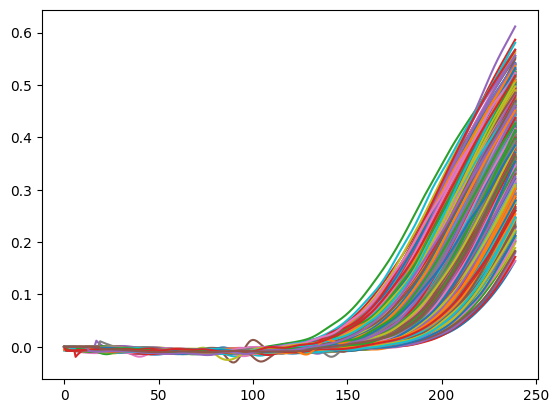

In [13]:
for i in range(INPUT_dec1.shape[0]):
  plt.plot(INPUT_dec1[i,:,0])

# **MULTIPLE TRAINING**

In [53]:
REFERENCE_PULSE_dec0 = np.tile(new_V82[0,:,0], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V82[0,:,1], (new_V82.shape[0],2,1)).swapaxes(1,2)

In [ ]:
Ntries= 15

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(Ntries):
  model_dec0 = model_definition(Nt_new)
  model_dec1 = model_definition(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=7.0e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=7.0e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  history_dec0 = model_dec0.fit(x=[trainX_dec0[:,:,0], trainX_dec0[:,:,1]],y=REF_train_dec0, epochs=250, batch_size = 32, shuffle = True, verbose=0)
  history_dec1 = model_dec1.fit(x=[trainX_dec1[:,:,0], trainX_dec1[:,:,1]],y=REF_train_dec1, epochs=250, batch_size = 32, shuffle = True, verbose=0)

  TOFN_dec0_REF_V82 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V82.shape[0],:,0],new_V82[:,:,0]])
  TOFN_dec1_REF_V82 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V82.shape[0],:,0],new_V82[:,:,1]])
  TOFN_dec0_REF_V55 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V55.shape[0],:,0],new_V55[:,:,0]])
  TOFN_dec1_REF_V55 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V55.shape[0],:,0],new_V55[:,:,1]])
  TOFN_dec0_REF_V28 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V28.shape[0],:,0],new_V28[:,:,0]])
  TOFN_dec1_REF_V28 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V28.shape[0],:,0],new_V28[:,:,1]])

  TOFN_V82 = TOFN_dec0_REF_V82-TOFN_dec1_REF_V82
  TOFN_V55 = TOFN_dec0_REF_V55-TOFN_dec1_REF_V55
  TOFN_V28 = TOFN_dec0_REF_V28-TOFN_dec1_REF_V28

  TOFN_V28_list.append(TOFN_V28)
  TOFN_V55_list.append(TOFN_V55)
  TOFN_V82_list.append(TOFN_V82)

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')


In [ ]:
for i in range(TOFN_V28_array.shape[0]):
  centroid_V28 = -1*np.mean(TOFN_V28_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  centroid_V82 = -1*np.mean(TOFN_V82_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82-0.2)) / 2
  mean_std = (np.std(TOFN_V82_array[i,:]) + np.std(TOFN_V55_array[i,:]) + np.std(TOFN_V28_array[i,:])) / 3

  epsilon = np.sqrt(mean_error_centroid**2 + mean_std**2)
  print('index: %d  %.3f %.3f %.3f' % (i, mean_std, mean_error_centroid,epsilon))

index: 0  0.093 0.038 0.100
index: 1  0.402 0.281 0.491
index: 2  0.272 0.013 0.273
index: 3  0.099 0.040 0.107
index: 4  0.101 0.031 0.106
index: 5  0.218 0.201 0.296
index: 6  0.114 0.027 0.117
index: 7  0.098 0.045 0.108
index: 8  0.104 0.037 0.110
index: 9  0.088 0.033 0.094
index: 10  0.096 0.032 0.101
index: 11  0.089 0.036 0.096
index: 12  0.121 0.023 0.123
index: 13  0.248 0.252 0.353
index: 14  0.096 0.046 0.106


In [57]:
epochs = 350
num_semillas = 10

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):
  #tf.random.set_seed(seed_value)

  model_dec0 = model_definition(Nt_new)
  model_dec1 = model_definition(Nt_new)

  #model_dec0 = model_definition_manual_weight_initialization(Nt_new)
  #model_dec1 = model_definition_manual_weight_initialization(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=1e-3)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=1e-3)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(x=[trainX_dec0[:,:,0], trainX_dec0[:,:,1]],y = REF_train_dec0, epochs=1, batch_size = 32, shuffle = True, verbose=1)
     history_dec1 = model_dec1.fit(x=[trainX_dec1[:,:,0], trainX_dec1[:,:,1]],y = REF_train_dec1, epochs=1, batch_size = 32, shuffle = True, verbose=1)
     
     loss_dec0.append(history_dec0.history['loss'])
     loss_dec1.append(history_dec1.history['loss'])

     
     TOFN_dec0_REF_V82 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V82.shape[0],:,0],new_V82[:,:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V82.shape[0],:,0],new_V82[:,:,1]])
     TOFN_dec0_REF_V55 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V55.shape[0],:,0],new_V55[:,:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V55.shape[0],:,0],new_V55[:,:,1]])
     TOFN_dec0_REF_V28 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V28.shape[0],:,0],new_V28[:,:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V28.shape[0],:,0],new_V28[:,:,1]])


     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = -1*np.mean(TOFN_V28) + np.mean(TOFN_V55)
     centroid_V82 = -1*np.mean(TOFN_V82) + np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - loss: 0.9575 
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - loss: 243.3633 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.7427
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 101.6013
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.7233
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 71.3607
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
6/6 ━

(array([2]), array([155])) 0.08164487277372251


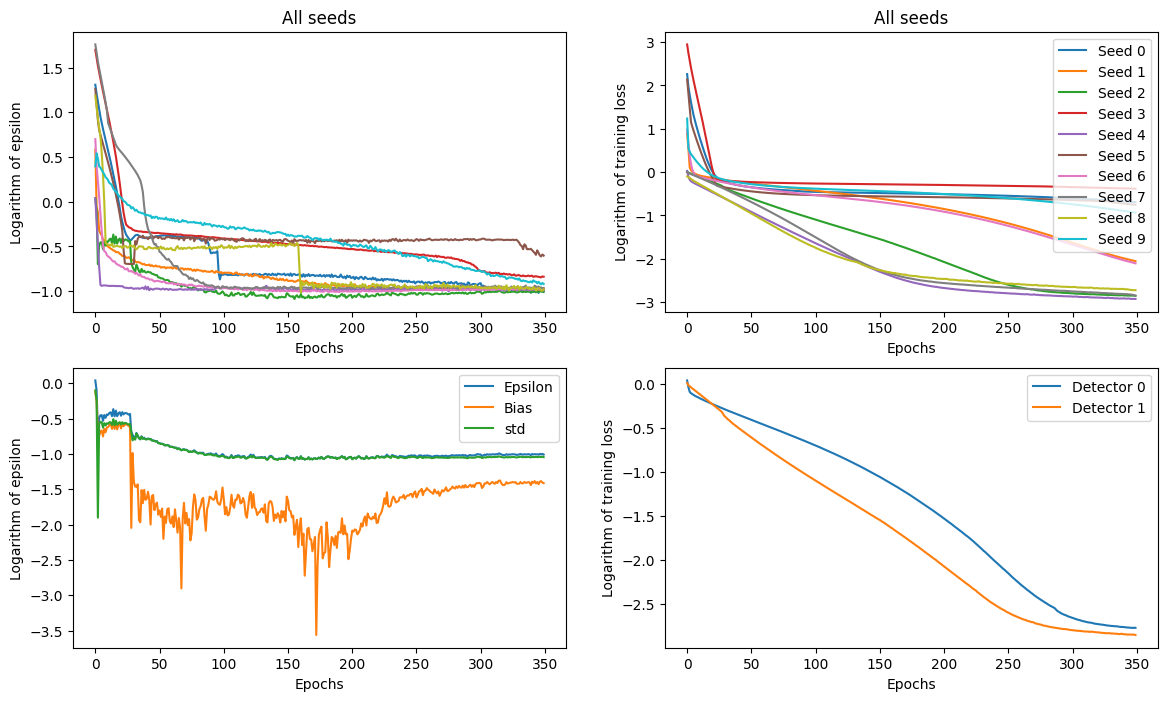

In [60]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 2
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  #plt.plot(np.log10(bias[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.188  FWHM(ns) = 0.200  std(ns) = 0.085
V55: CENTROID(ns) = 0.003  FWHM(ns) = 0.191  std(ns) = 0.081
V28: CENTROID(ns) = -0.198  FWHM(ns) = 0.172  std(ns) = 0.073


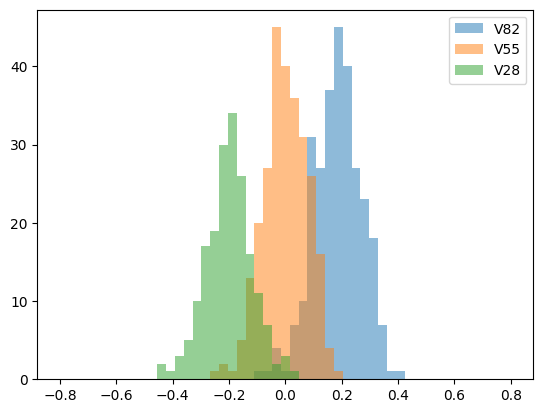

In [61]:
epoch = 155
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_V82_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(TOFN_V55_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(TOFN_V28_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

(240, 12)
MSE_dec0: 0.002 MSE_dec1: 0.007


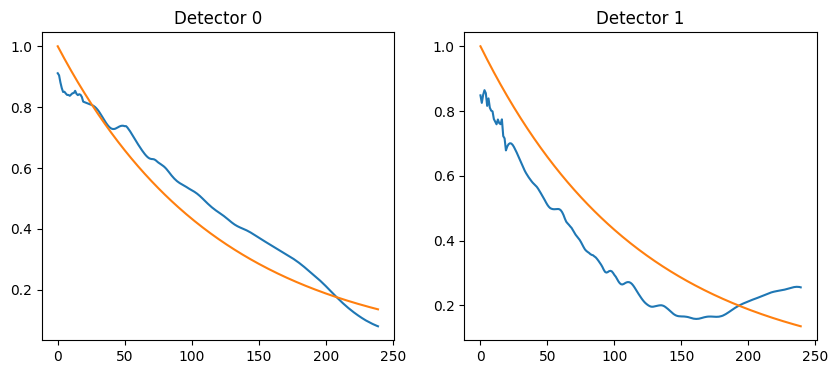

In [71]:
pesos_after_training_dec0 = np.array(model_dec0.layers[2].get_weights()[0])
pesos_after_training_dec1 = np.array(model_dec1.layers[2].get_weights()[0])
print(pesos_after_training_dec0.shape)


index = 10
plt.figure(figsize = (10,4))

plt.subplot(121)
plt.plot(pesos_after_training_dec0[:,index])
plt.plot(weights[:,index])
plt.title('Detector 0')

plt.subplot(122)
plt.plot(pesos_after_training_dec1[:,index])
plt.plot(weights[:,index])
plt.title('Detector 1');

MSE_dec0 = 0.5*np.sum((pesos_after_training_dec0[:,index] - weights[:,index])**2) / len(weights[:,index])
MSE_dec1 = 0.5*np.sum((pesos_after_training_dec1[:,index] - weights[:,index])**2) / len(weights[:,index])
print('MSE_dec0: %.3f MSE_dec1: %.3f' % (MSE_dec0,MSE_dec1))

# **ENSEMBLE MODEL**

In [64]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)


Weighted mean:
V82: CENTROID(ns) = 0.195  FWHM(ns) = 0.218  std(ns) = 0.093
V55: CENTROID(ns) = 0.008  FWHM(ns) = 0.178  std(ns) = 0.075
V28: CENTROID(ns) = -0.220  FWHM(ns) = 0.207  std(ns) = 0.088


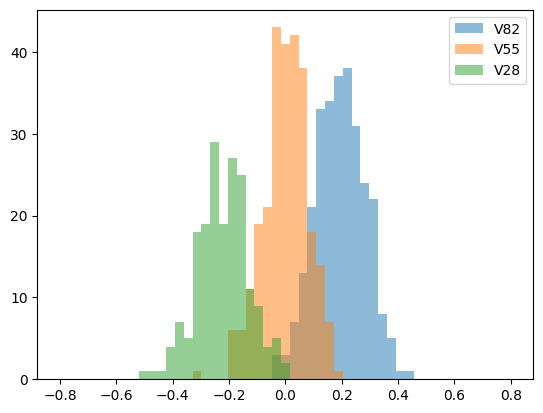

In [65]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(weighted_mean_V82) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(weighted_mean_V55) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(weighted_mean_V28) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print('Weighted mean:')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))